In [35]:
import re
import string
import unicodedata

import contractions
import en_core_web_sm
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from pandas.core.common import flatten
from textstat import textstat
import swifter


def load_raw_data(data_path):
    df = pd.read_csv(data_path, usecols=["Title", "Body", "label"], encoding="utf-8")
    df.columns = [x.lower() for x in df.columns]
    return df


def load_stopwords(language="english"):
    stopword_list = stopwords.words(language)
    stopword_list.remove("no")
    stopword_list.remove("not")
    stopword_list.append("hi")
    stopword_list.append("please")

    return stopword_list


def strip_html_tags(text):
    tag_regex = re.compile(r"<[^>]+>")
    text = tag_regex.sub("", text)

    html_escape_table = {
        "&amp;": "and",
        "&quot;": '"',
        "&apos;": "'",
        "&gt;": ">",
        "&lt;": "<",
    }

    for html_esc in html_escape_table:
        text = text.replace(html_esc, html_escape_table[html_esc])

    return text


def strip_urls(text):
    # slow...
    # from geeksforgeeks.org/python-check-url-string
#     url_regex = re.compile(
#         r"(?i)\b((?:http?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)"
#         r"(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()"
#         r"<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
#     )
#     text = url_regex.sub("replacedurl", text)

    stop_words = ("https://", "http://")
    text = " ".join([x for x in text.split() if not x.startswith(stop_words)])
    return text


def convert_accented_characters(text):
    text = (
        unicodedata.normalize("NFKD", text)
        .encode("ascii", "ignore")
        .decode("utf-8", "ignore")
    )
    return text


def expand_contractions(text):
    return contractions.fix(text).lower()


def remove_punctuation(text):
    # Remove punctuation
    text = re.sub("[^A-Za-z0-9 ]+", "", text)
    text = " ".join(text.split())

    return text


def lemmatize_text(text, nlp):

    text = nlp(text)
    text = " ".join(
        [word.lemma_ if word.lemma_ != "-PRON-" else word.text for word in text]
    )
    return text


def remove_stopwords(text):
    filtered_tokens = [token for token in text.split() if token not in load_stopwords()]
    filtered_text = " ".join(filtered_tokens)
    return filtered_text


def remove_multiple_spaces(text):
    text = text.replace(r"\n", "")
    text = re.sub(r"\s+", " ", text)

    return text


def calc_num_sentences(text):
    return textstat.sentence_count(text)


def calc_num_words(text):
    return len(text.split())


def calc_num_chars(text):
    return textstat.char_count(text, ignore_spaces=True)


def calc_num_code_blocks(text):
    return text.count("<code>")


def calc_num_punctuation_chars(text):
    return len([x for x in text if x in set(string.punctuation)])


def calc_num_words_in_code_blocks(text):
    code_text = list(flatten(re.findall(r"<code>(.*?)</code>", text)))

    n_words = 0
    for snippet in code_text:
        n_words += len(snippet.split())

    return n_words


def calc_word_len_mean(text):
    words = text.split()
    word_lengths = np.array([len(x) for x in words])

    return np.mean(word_lengths)


def calc_word_len_median(text):
    words = text.split()
    word_lengths = np.array([len(x) for x in words])

    return np.median(word_lengths)


def calc_word_len_max(text):
    words = text.split()
    word_lengths = np.array([len(x) for x in words])

    return np.max(word_lengths)


def normalize_text(doc, deep_clean=False, nlp=None):
    # FOR BERT, Don't need to remove punctuation, don't need to remove stop-words
    if not deep_clean:
        doc = doc.lower()

        doc = strip_html_tags(doc)
        doc = strip_urls(doc)
        doc = convert_accented_characters(doc)
        doc = expand_contractions(doc)
        doc = remove_multiple_spaces(doc)

        # Tried to use the normalise library, but too slow
        # Would use it for converting to/from numbers, percents, abbreviations

        # Depending on text corpus, would want to process emojis as well
        # However, SO is not very emoji friendly

    else:
        assert doc == doc.lower(), "text has not been cleaned yet."
        doc = remove_punctuation(doc)
        doc = lemmatize_text(doc, nlp=nlp)
        doc = remove_stopwords(doc)

    return doc


def run_preprocessing():
    df = load_raw_data("../data/raw/interview_dataset.csv")

    # The removal of HTML tags will also remove the code block delimiter
    df["num_code_blocks"] = df["body"].apply(calc_num_code_blocks)
    df["num_words_code_blocks"] = df["body"].apply(calc_num_words_in_code_blocks)

    df["light_cleaned_title"] = (
        df["title"].swifter.allow_dask_on_strings().apply(normalize_text)
    )
    df["light_cleaned_body"] = (
        df["body"].swifter.allow_dask_on_strings().apply(normalize_text)
    )

    df["light_cleaned_text"] = (
        df["light_cleaned_title"] + " " + df["light_cleaned_body"]
    )

    # Calculate meta-data features
    df["num_sentences_body"] = df["light_cleaned_body"].apply(calc_num_sentences)
    df["num_words_title"] = df["light_cleaned_title"].apply(calc_num_words)
    df["num_words_body"] = df["light_cleaned_body"].apply(calc_num_words)
    df["num_chars_title"] = df["light_cleaned_title"].apply(calc_num_chars)
    df["num_chars_body"] = df["light_cleaned_body"].apply(calc_num_chars)
    df["num_punctuation"] = df["light_cleaned_body"].apply(calc_num_punctuation_chars)
    df["word_len_mean"] = df["light_cleaned_body"].apply(calc_word_len_mean)
    df["word_len_median"] = df["light_cleaned_body"].apply(calc_word_len_median)
    df["word_len_max"] = df["light_cleaned_body"].apply(calc_word_len_max)

    nlp = en_core_web_sm.load()
    # Normalize Text
    df["cleaned_title"] = (
        df["light_cleaned_title"]
        .swifter.allow_dask_on_strings()
        .apply(normalize_text, deep_clean=True, nlp=nlp)
    )
    df["cleaned_body"] = (
        df["light_cleaned_body"]
        .swifter.allow_dask_on_strings()
        .apply(normalize_text, deep_clean=True, nlp=nlp)
    )

    df["cleaned_text"] = df["cleaned_title"] + " " + df["cleaned_body"]
    df["cleaned_text"] = df["cleaned_text"].apply(remove_multiple_spaces)
    df["num_words_body_cleaned"] = df["cleaned_body"].apply(calc_num_words)
    df["pct_words_meaning"] = df["num_words_body_cleaned"] / df["num_words_body"]

    df.to_parquet("../data/processed/cleaned.parquet")

    return df

In [36]:
df = run_preprocessing()

In [37]:
df

,body,title,label,num_code_blocks,num_words_code_blocks,light_cleaned_title,light_cleaned_body,light_cleaned_text,num_sentences_body,num_words_title,...,num_chars_body,num_punctuation,word_len_mean,word_len_median,word_len_max,cleaned_title,cleaned_body,cleaned_text,num_words_body_cleaned,pct_words_meaning
0,<p>Hi I'm new to <code>Ruby on Rails</code>. I...,RUBY: most common number for Users,1,1,3,ruby: most common number for users,hi i am new to ruby on rails. i created users ...,ruby: most common number for users hi i am new...,1,6,...,234,7,4.034483,4.0,11,ruby common number user,new ruby rail create user device profile creat...,ruby common number user new ruby rail create u...,28,0.482759
1,<p>I know that StringBuffer class is synchroni...,What exactly does it mean when they say that S...,0,1,4,what exactly does it mean when they say that s...,i know that stringbuffer class is synchronized...,what exactly does it mean when they say that s...,1,21,...,313,11,5.589286,4.0,15,exactly mean say stringbuffer class synchroniz...,know stringbuffer class synchronizedor threads...,exactly mean say stringbuffer class synchroniz...,31,0.553571
2,<p>I have a search engine on PHP that have ind...,Scan a webpage and get the video embed url only,1,1,0,scan a webpage and get the video embed url only,i have a search engine on php that have indexe...,scan a webpage and get the video embed url onl...,1,10,...,555,39,4.663866,3.0,70,scan webpage get video embed url,search engine php index movie site want get vi...,scan webpage get video embed url search engine...,49,0.411765
3,<p>Is there any way to get ICY metadata from s...,ICY metadata support with ffmpeg,0,0,0,icy metadata support with ffmpeg,is there any way to get icy metadata from shou...,icy metadata support with ffmpeg is there any ...,1,5,...,191,5,4.547619,4.0,17,icy metadata support ffmpeg,way get icy metadata shoutcast stream use ffmp...,icy metadata support ffmpeg way get icy metada...,22,0.523810
4,<p>For my website I want to have divs out of t...,Use jQuery or Javascript to move elements into...,1,0,0,use jquery or javascript to move elements into...,for my website i want to have divs out of the ...,use jquery or javascript to move elements into...,1,9,...,190,10,4.523810,4.0,24,use jquery javascript move element view,website want div viewport ie left3000pxtop1500...,use jquery javascript move element view websit...,18,0.428571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,<p>I'm looking for good library for iphone to ...,How can I create better looking charts than th...,1,0,0,how can i create better looking charts than th...,i am looking for good library for iphone to dr...,how can i create better looking charts than th...,1,13,...,283,12,4.716667,4.0,12,create better looking chart generate core plot,look good library iphone draw chart pie chart ...,create better looking chart generate core plot...,36,0.600000
99996,<p>I am using Jquery with <code>Ajax</code> <c...,"Autocomplete Ajax asp.net MVC, Display text",0,5,2,"autocomplete ajax asp.net mvc, display text",i am using jquery with ajax autocomplete to re...,"autocomplete ajax asp.net mvc, display text i ...",1,6,...,1037,170,6.284848,4.0,44,autocomplete ajax aspnet mvc display text,use jquery ajax autocomplete return datum kind...,autocomplete ajax aspnet mvc display text use ...,89,0.539394
99997,<p>I'm using the following formula to find a v...,COUNTIF showing inconsistent behavior,0,0,0,countif showing inconsistent behavior,i am using the following formula to find a val...,countif showing inconsistent behavior i am usi...,1,4,...,331,29,4.243590,3.5,16,countif show inconsistent behavior,use follow formula find value cds et al spread...,countif show inconsistent behavior use follow ...,40,0.512821
99998,<p>Using the fetch API in modern browsers (or ...,Is it possible to cause a fetch's text() funct...,0,2,2,is it possible to because a fetch's text() fun...,using the fetch ap

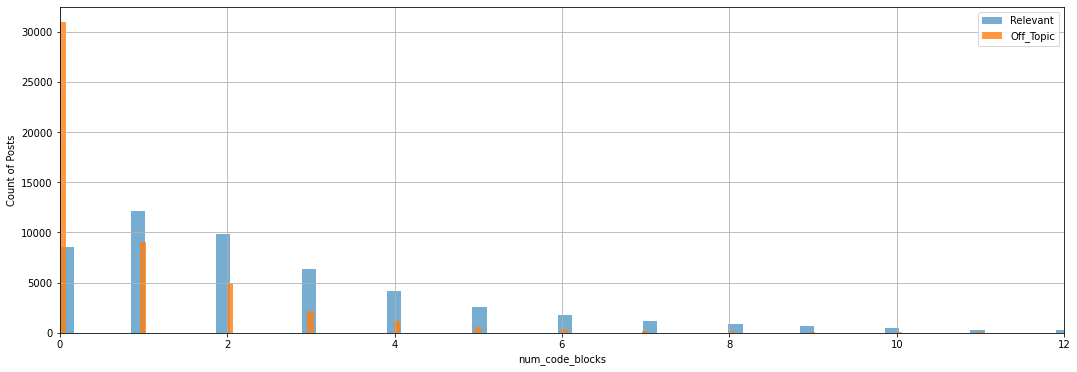

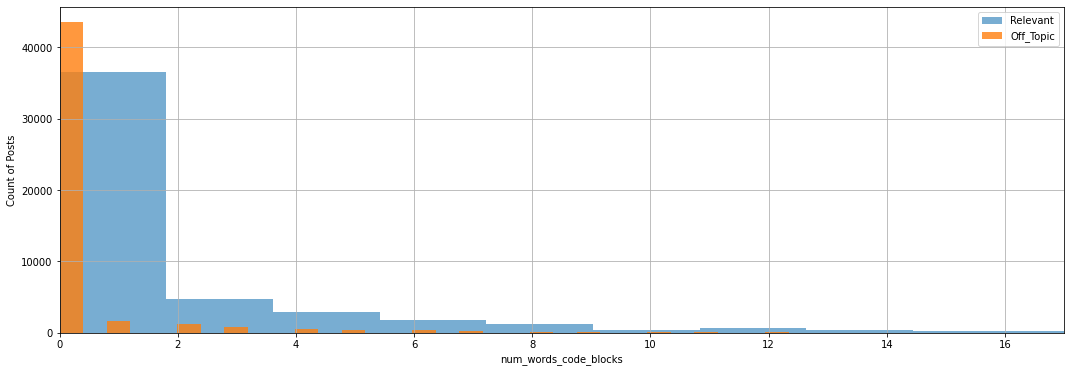

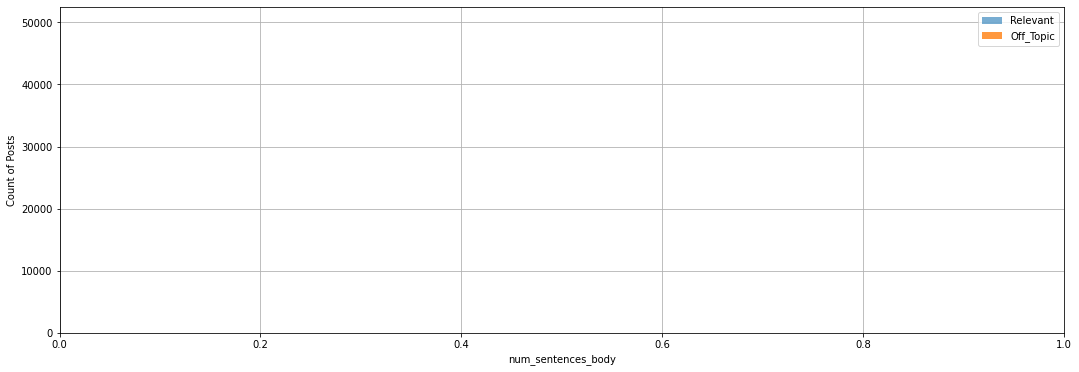

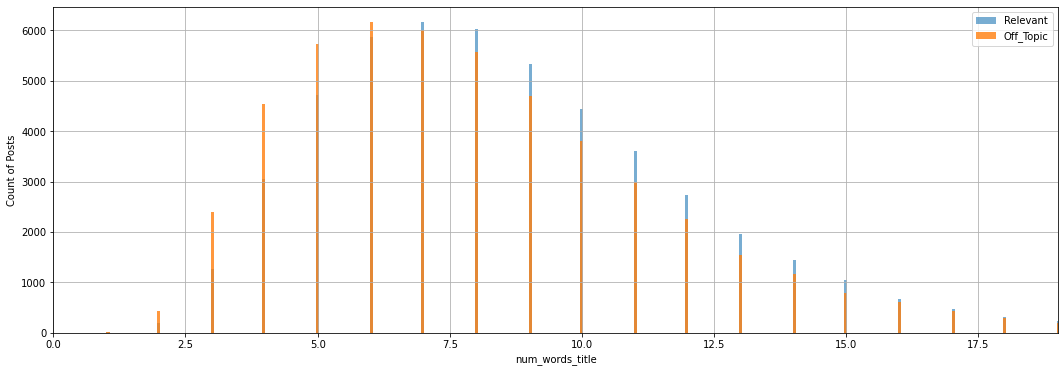

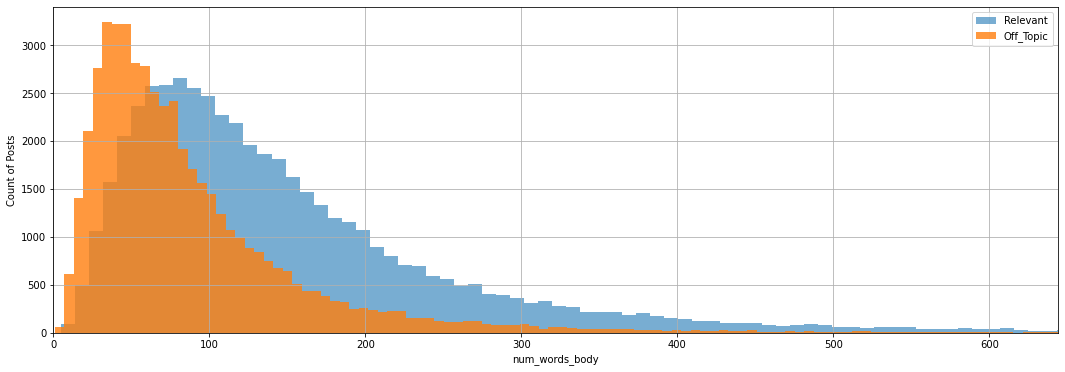

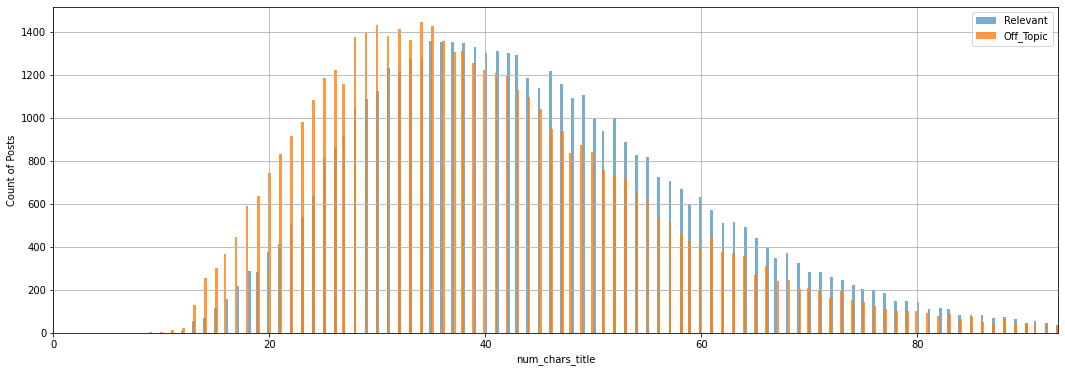

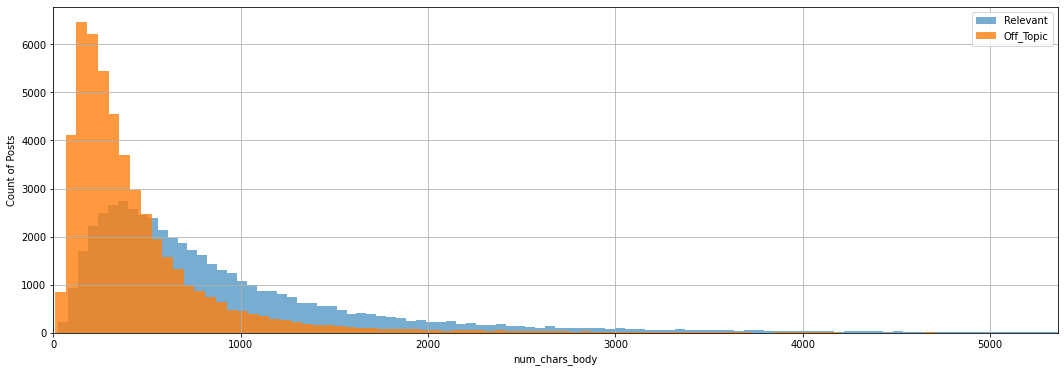

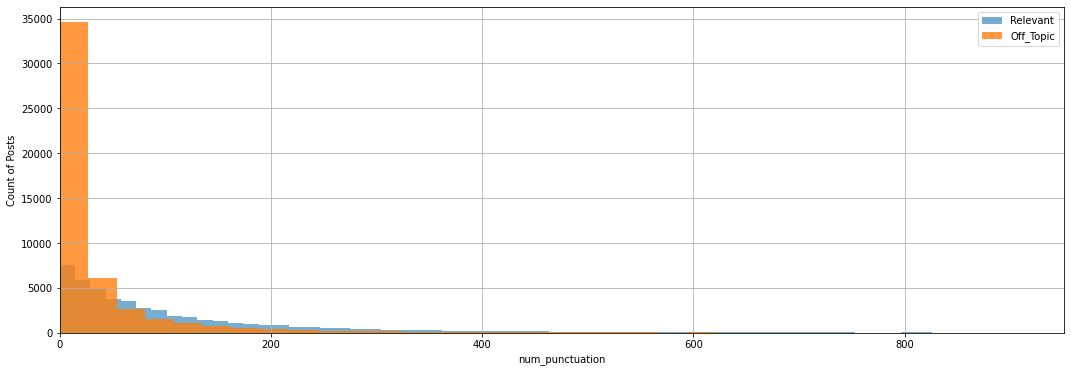

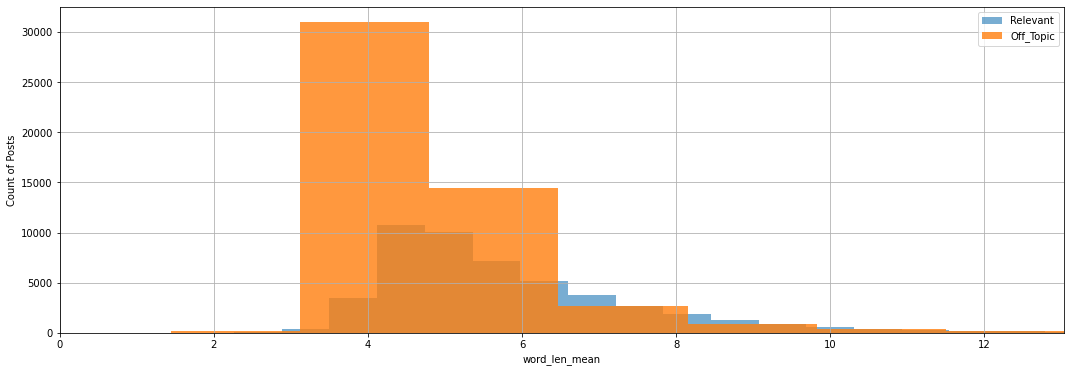

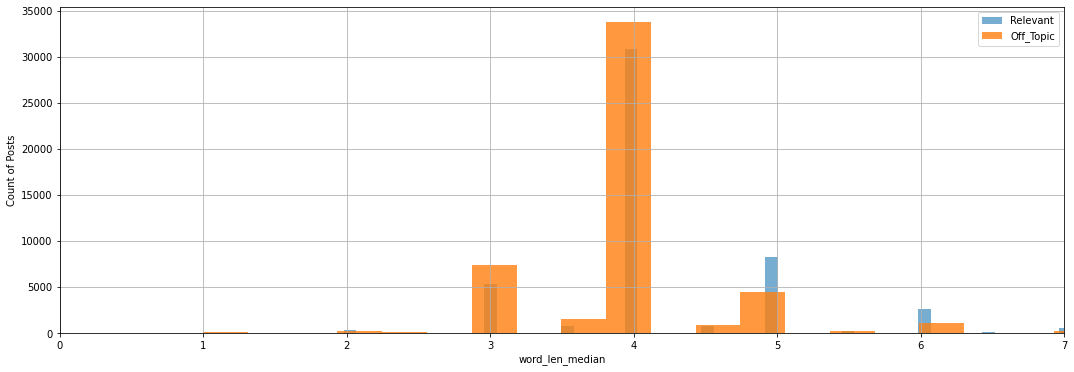

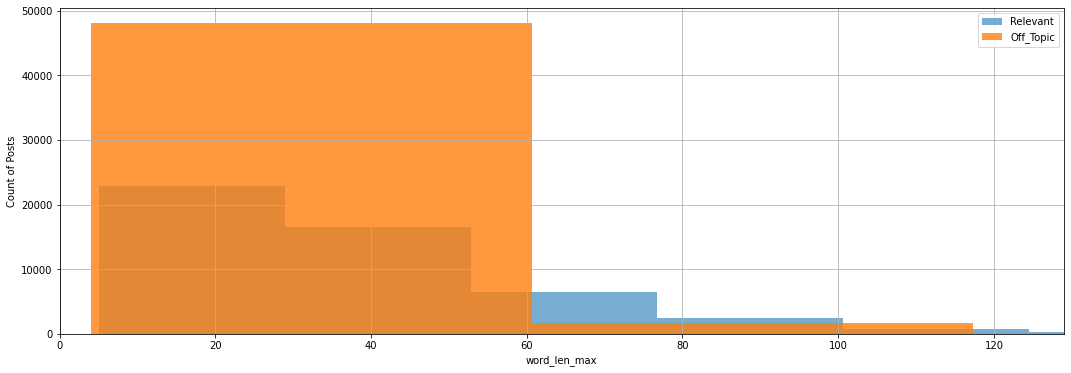

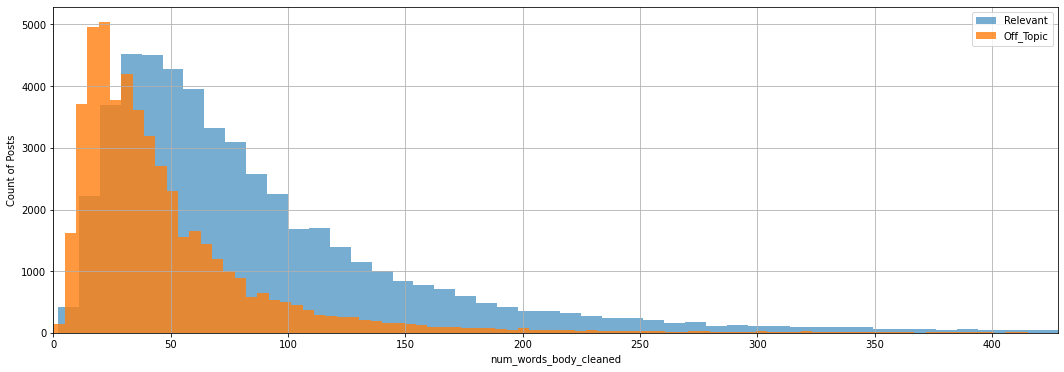

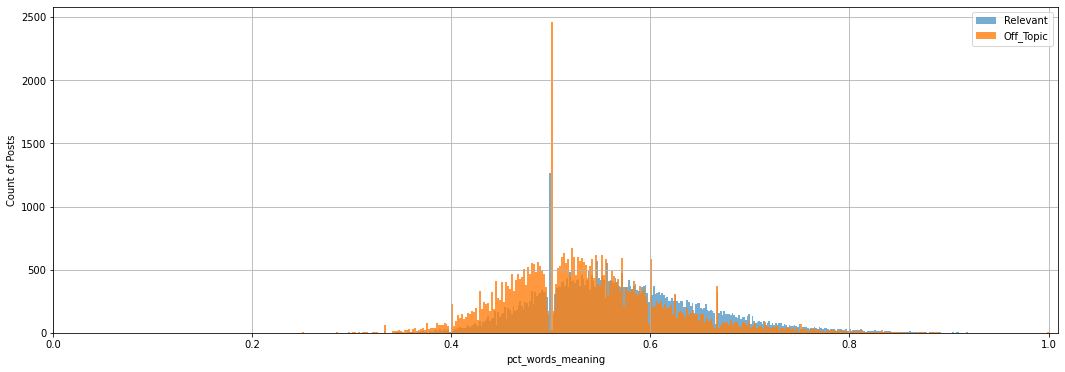

In [41]:
# Some EDA
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (18.0, 6.0)
bins = 500

for col, x in enumerate(df.dtypes):
    if x != "object" and df.columns[col] != "label":
        col_nm = df.columns[col]
        plt.hist(df[df['label'] == 0][col_nm], alpha = 0.6, bins=bins, label='Relevant')
        plt.hist(df[df['label'] == 1][col_nm], alpha = 0.8, bins=bins, label='Off_Topic')
        plt.xlabel(col_nm)
        plt.ylabel('Count of Posts')
        plt.legend(loc='upper right')
        
        if df[col_nm].max() > 10:
            plt.xlim(0,df[col_nm].quantile(0.99))
        else:
            plt.xlim(0,df[col_nm].max())
        plt.grid()
        plt.show()


In [43]:
!pip install wordcloud

     |████████████████████████████████| 364 kB 3.0 MB/s eta 0:00:01


In [44]:
from wordcloud import WordCloud


corpus_0 = df[df.label == 0].cleaned_body.to_list()
corpus_1 = df[df.label == 1].cleaned_body.to_list()

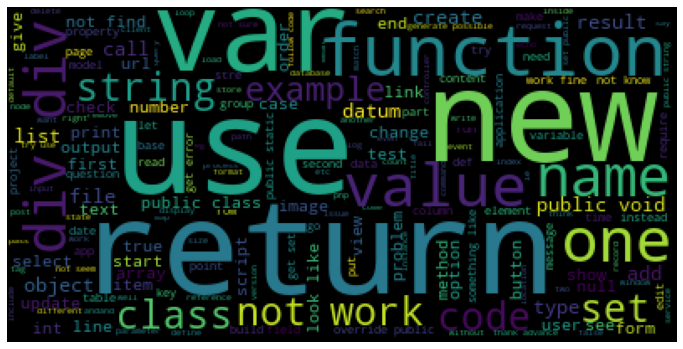

In [45]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_0))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

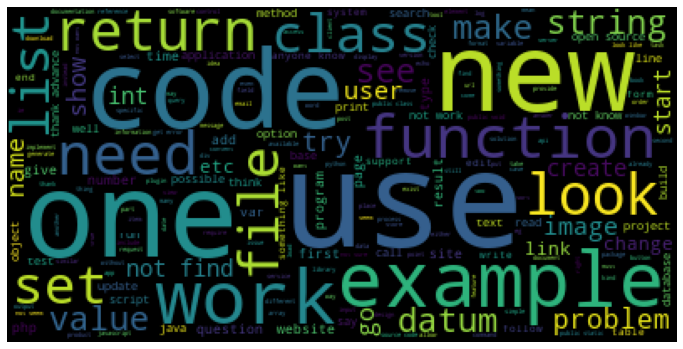

In [46]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(
                          background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_1))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()